<a href="https://colab.research.google.com/github/mroesler101/StockPredictor/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# I used this source to help me find a huge NASDAQ csv file containing stock names: https://towardsdatascience.com/downloading-historical-stock-prices-in-python-93f85f059c1f
# Market categories feature in CSV file: Q = NASDAQ Global Select MarketSM; G = NASDAQ Global MarketSM; S = NASDAQ Capital Market
# Round lot size feature: securities to be traded on exchange (typically 100)
!pip install --upgrade yfinance
import yfinance as yf # Yahoo finance will provide historical stock prices to use for the predictions
import datetime
import time
import requests
import io
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from joblib import dump, load 
from sklearn.preprocessing import StandardScaler

def collectDataframe(start, end):
  # List of stocks in NASDAQ found from towardsdatascience.com to have a collection of stocks to form a model
  url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
  s = requests.get(url).content
  companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
  Symbols = companies['Symbol'].tolist() #create list for the various companies
  sty = int(start[0])
  stm = int(start[1])
  std = int(start[2])
  ey = int(end[0])
  em = int(end[1])
  ed = int(end[2])
  if (sty > ey):
    print("Start year must be lower than end year")
    return
  if (sty == ey):
    if (stm > em):
      print("End month has to be after start month")
      return
    if (stm == em):
      if (std > ed):
        print("End day has to be after start day")
        return
  start = datetime.datetime(sty,stm,std) # Start and end time to look at stock history (1 month from november-december 2020 in this model)
  end = datetime.datetime(ey,em,ed)
# use arguments to find date 
# This creates an empty list

  stock_final = pd.DataFrame()
# Go through every symbol that we added to the list
  for i in Symbols:  
    
    # This prints each symbol that is being acquired for
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # Yahoo Finance - finds and collects the information needed to complete the dataframe and list for predictions
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # This appends the individual stock prices to the list
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
  dump(stock_final, 'ticker.pkl')
  return stock_final

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.59)


In [3]:
def timeframe(start, end):
  sty = int(start[0])
  stm = int(start[1])
  std = int(start[2])
  ey = int(end[0])
  em = int(end[1])
  ed = int(end[2])
  if (sty > ey):
    print("Start year must be lower than end year")
    return
  if (sty == ey):
    if (stm > em):
      print("End month has to be after start month")
      return
    if (stm == em):
      if (std > ed):
        print("End day has to be after start day")
        return
  start = datetime.datetime(sty,stm,std) # Start and end time to look at stock history (1 month from november-december 2020 in this model)
  end = datetime.datetime(ey,em,ed)
  dump(start, 'start.pkl')
  dump(end,'end.pkl')
  return start, end

#stock_final = timeframe(start, end)
#timeframe(start,end)

In [4]:
def nasdaq(ticker, days):
  stock_final = load('ticker.pkl')
  start = load('start.pkl')
  end = load('end.pkl')
  days = int(days)
  if (days < 2):
    print("Invalid number of days to predict")
    return
  if stock_final.query("Name == '{}'".format(ticker)).empty:
    print("Invalid NASDAQ ticker or information not found")
    return
  #st = stock_final.query("Name == '{}'".format(ticker))
  st = yf.download(ticker,start=start, end=end, progress=False)
  #st = st.drop(columns=['Name'])
  st.plot(y='Adj Close') 
  plt.title('Date V. Actual Adj. Closing Price')
  plt.xlabel('Date (Days)')
  plt.ylabel('Adj. Closing Price ($)')
  plt.show()  

  #st = my_tick('AAPL')

  #stock_final
  #st = stock_final.query("Name == 'AMZN'") # This line is vital for the program to pick a specific stock to look into
  #st = st.drop(columns=['Name'])
  # Remove all names to make fitting and training accurate with just the numbers in the adjusted closing price (corporate decisions)
  
  #days = 2 # Number of days you want to predict
  #Makes another column called prediction

  st['Prediction'] = st[['Adj Close']].shift(-days)

  X = np.array(st.drop(['Prediction'],1))

#Take the last 'days' rows to predict the next # of days
  X = X[:-days]
#print(X)

  y = np.array(st['Prediction'])
# Get all of the y values except the last 'days' of rows
  y = y[:-days]
#print(y)

#Train 80% and test 20% of the data
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# drops all days before the prediction column, saves only # of days to graph
  stockprice = np.array(st.drop(['Prediction'],1))[-days:]

 # from sklearn.linear_model import LinearRegression
 # lr = LinearRegression()
# Train the model
 # lr.fit(x_train, y_train)
 # prediction = lr.predict(stockprice)
 # print(prediction)
 # plt.plot(prediction)

  regressor = SVR(kernel = 'poly')
  regressor.fit(x_train, y_train)
  y_pred = regressor.predict(stockprice)

  print(y_pred)
  print("SVR score:", regressor.score(x_test,y_test))

  count=y_pred[0]
  day=0
  max = y_pred[0]
  for i in range(0,days-1):
    if (y_pred[i] < y_pred[i+1]):
      max = y_pred[i+1]
      day = i+2 # for the accurate number of days and not the array number
  print("The highest predicted price in", days, "days is day", day, f"with a predicted price of ${round(max, 2)}")
  if (day==0):
    print("This means that the stock price is predicted to go down in the next", days, "days")
# When day 0 is the lowest, that means that the stock price is predicted to go down
  plt.title(f'{ticker} SVR Model: Days V. Predicted Adj. Closing Price')
  plt.ylabel('Predicted Stock Price Average ($)')
  plt.xlabel('Time (Days)')
  plt.ticklabel_format(useOffset=False)
  plt.plot(y_pred)
  plt.show()
  return

0 : AAIT,1 : AAL,2 : AAME,3 : AAOI,4 : AAON,5 : AAPL,6 : AAVL,
1 Failed download:
- AAVL: No data found for this date range, symbol may be delisted
7 : AAWW,8 : AAXJ,9 : ABAC,
1 Failed download:
- ABAC: No data found for this date range, symbol may be delisted
10 : ABAX,
1 Failed download:
- ABAX: No data found for this date range, symbol may be delisted
11 : ABCB,12 : ABCD,
1 Failed download:
- ABCD: No data found for this date range, symbol may be delisted
13 : ABCO,14 : ABCW,
1 Failed download:
- ABCW: No data found for this date range, symbol may be delisted
15 : ABDC,
1 Failed download:
- ABDC: No data found, symbol may be delisted
16 : ABGB,
1 Failed download:
- ABGB: No data found for this date range, symbol may be delisted
17 : ABIO,18 : ABMD,19 : ABTL,
1 Failed download:
- ABTL: No data found for this date range, symbol may be delisted
20 : ABY,
1 Failed download:
- ABY: No data found for this date range, symbol may be delisted
21 : ACAD,22 : ACAS,
1 Failed download:
- ACAS: N

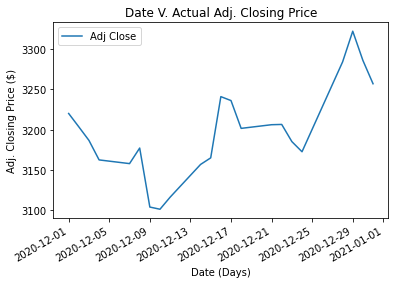

[3177.04283872 3175.87165957]
SVR score: -0.9048841555256566
The highest predicted price in 2 days is day 0 with a predicted price of $3177.04
This means that the stock price is predicted to go down in the next 2 days


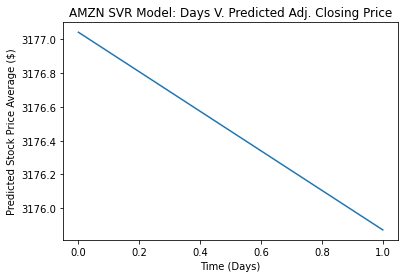

In [6]:
start = [2020, 12, 1]
end = [2021, 1, 1]
collectDataframe(start,end)
timeframe(start, end)
nasdaq('AMZN', 2)